# Model 4: Inception ResNet
We next tried to use another model trained with the same ImageNet dataset that traditionally outperforms VGG16:- Inception ResNet 

In [3]:
### Installing the package required to import functions from notebooks
#!pip install import-ipynb

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import import_ipynb
import os
from google.colab import files
files.upload()
os.chdir("/content/drive/MyDrive/Capstone Benchmark Models")

### We will import all the data_preparation functions
from  data_preparation import *


### We will import all visualization functions
from  plots import *

Saving kaggle.json to kaggle.json
importing Jupyter notebook from data_preparation.ipynb


Saving kaggle.json to kaggle (8).json
importing Jupyter notebook from plots.ipynb


In [20]:
### Importing necessary libraries

%matplotlib inline


from keras.models import Sequential,Model
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras import datasets, layers
from keras.applications import InceptionResNetV2

## Preparing the Training and Test DataSet

In [7]:
### Dataset is downloaded
download_kaggle()

 98% 198M/203M [00:12<00:00, 80.5MB/s]
100% 203M/203M [00:12<00:00, 16.9MB/s]


In [8]:
### Images are extracted
image_files=image_extract()


In [9]:
### Preparing independent X
X=image_preprocessing_step(image_files,"inception")

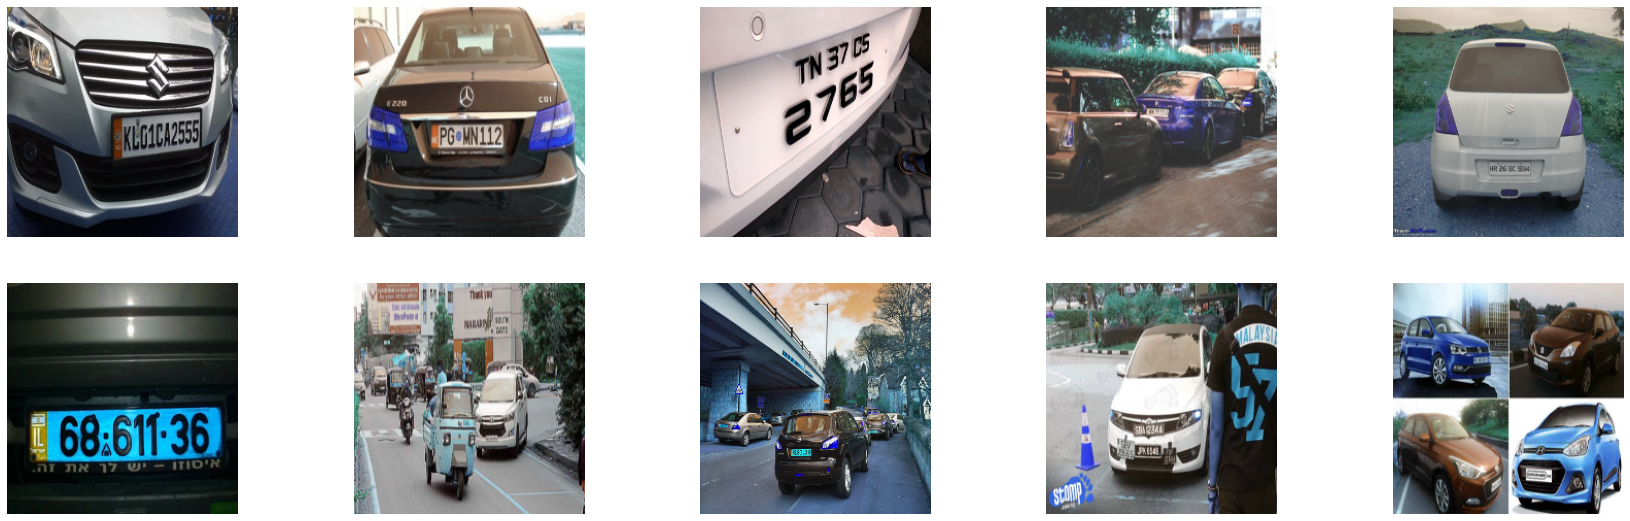

In [10]:
### Showing first 10 images
images_show(10,X)

In [11]:
### Getting a list annotations file

annotations_files=annotations_extract()

In [12]:
### Extracting boundaries from annotations

y=boundary_extract(annotations_files)

In [30]:
### Test train prepartion for 90/10 split
X_train, X_val, y_train, y_val,X_test,y_test=train_test(X,y)


### Model

In [31]:
# Create the model
# We are using a Inception ResNet model for regression to predict the boundaries of the license plate
# The model has been tuned to optimise MSE

inception_resnet = Sequential()
inception_resnet.add(InceptionResNetV2(weights="imagenet",include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE,3)))


x=Flatten()(inception_resnet.output)
x=Dense(128, activation="relu")(x)
x=Dense(128, activation="relu")(x)
x=Dense(64, activation="relu")(x)
x=Dense(32, activation="relu")(x)
x=Dense(16, activation="relu")(x)
x=Dense(4,activation="sigmoid")(x)

model=Model(inputs=inception_resnet.input,outputs=x)



model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2_input (  [(None, 224, 224, 3)]    0         
 InputLayer)                                                     
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 38400)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               4915328   
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 64)                8256

In [32]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam

checkpoint = ModelCheckpoint('my_model.h5', monitor= 'mse', mode= 'min', save_best_only = True, verbose= 1)
lr_reduce = ReduceLROnPlateau(monitor='mse', factor=0.6, patience=8, verbose=1, mode='min', min_lr=5e-5)

### We are using mean squared error loss function
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['MeanAbsoluteError','mse'])

In [33]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
10/10 [==============================] - 28s 975ms/step - loss: 0.0558 - mean_absolute_error: 0.1843 - mse: 0.0558 - val_loss: 0.0572 - val_mean_absolute_error: 0.1936 - val_mse: 0.0572
Epoch 2/100
10/10 [==============================] - 6s 607ms/step - loss: 0.0255 - mean_absolute_error: 0.1148 - mse: 0.0255 - val_loss: 0.0459 - val_mean_absolute_error: 0.1692 - val_mse: 0.0459
Epoch 3/100
10/10 [==============================] - 6s 604ms/step - loss: 0.0209 - mean_absolute_error: 0.0959 - mse: 0.0209 - val_loss: 0.0502 - val_mean_absolute_error: 0.1719 - val_mse: 0.0502
Epoch 4/100
10/10 [==============================] - 6s 610ms/step - loss: 0.0231 - mean_absolute_error: 0.1002 - mse: 0.0231 - val_loss: 0.0870 - val_mean_absolute_error: 0.2318 - val_mse: 0.0870
Epoch 5/100
10/10 [==============================] - 6s 624ms/step - loss: 0.0183 - mean_absolute_error: 0.0773 - mse: 0.0183 - val_loss: 0.0547 - val_mean_absolute_error: 0.1645 - val_mse: 0.0547
Epoch 6/100
10

In [34]:
### Saving the model
model.save('inception_resnet.h5', overwrite=True) 


In [35]:
# Validation dataset performance
scores = model.evaluate(X_test, y_test, verbose=0)
print("The Mean Squared Error : %.2f%%" % (scores[2]*100))
print("The Mean Absolute Error : %.2f%%" % (scores[1]*100))

The Mean Squared Error : 1.22%
The Mean Absolute Error : 6.90%


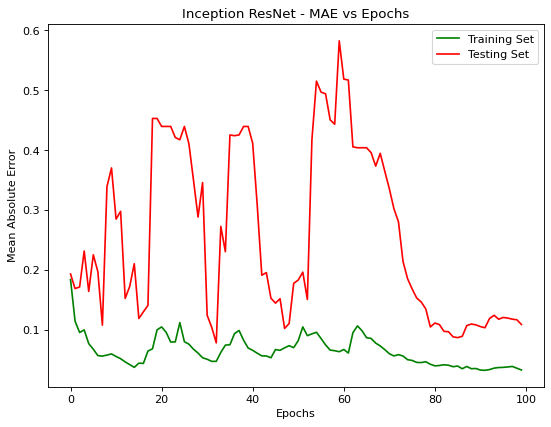

In [36]:
### Plotting Evaluation Function- Mean Absolute Error
plot_scores(train,"Inception ResNet")

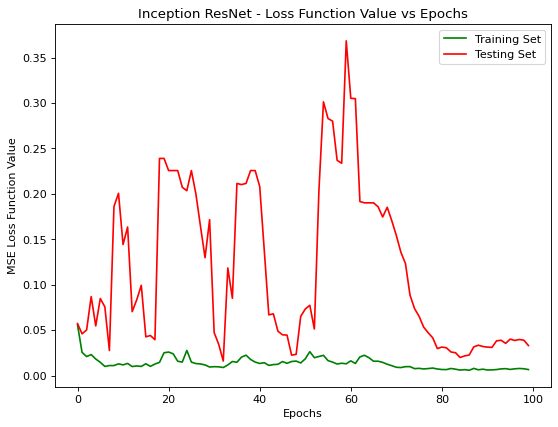

In [37]:
### Plotting Loss Function
plot_loss(train,"Inception ResNet")

In [38]:
### Predicting output boundary values
y_cnn = model.predict(X_test)

3/3 [==============================] - 3s 183ms/step


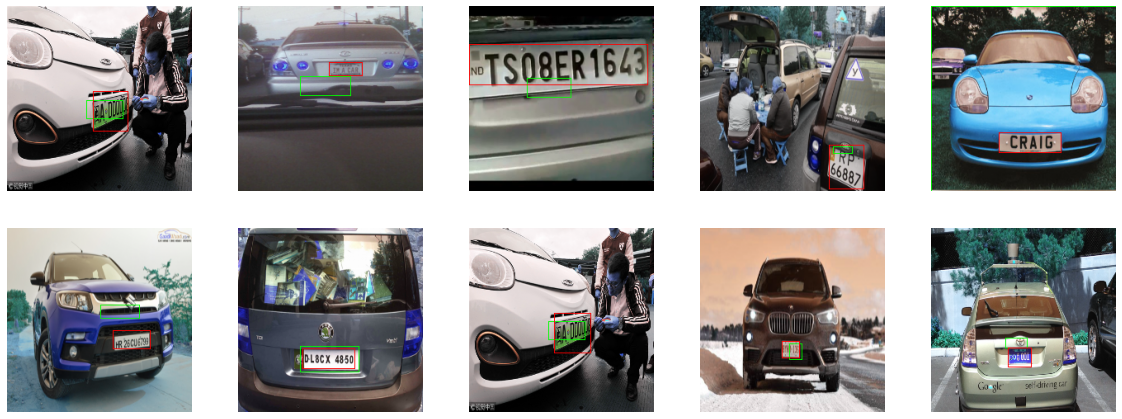

In [39]:
### Plotting the boundaries based on prediction

boundaries(10,y_cnn,y_test,X_test,"/output")